# Capstone Project - The Battle of the Neighborhoods

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

_Everything said in the following haven't been professionnally fact checked (just me) and eventually can be wrong, exagerated or simply neglected as the objective here is not as much to be strictly exact than to make an interesting and compelling story for a data science project in the context of the IBM course at coursera, with the condition to use Foursquare API.  
So don't take anything said here too seriously as the subject can get controversial._  

Due to a recent raise of vandlism in Paris, **the police department of Paris** contracted us to make a report on the situation of Paris.  
We'll first **find a list of the highest vandalism rate neighborhood** and attempt to **find a correlation between vandalism and the vicinity characteristics**.  

## Data <a name="data"></a>

Here we'll try to answer this simple question, using :  
* **Foursquare API**: https://fr.foursquare.com/  
* **Paris anomalie dataset** : https://opendata.paris.fr/explore/dataset/dans-ma-rue/information/?disjunctive.type&disjunctive.soustype&disjunctive.code_postal&disjunctive.ville&disjunctive.arrondissement&disjunctive.prefixe&disjunctive.conseilquartier
* **Paris arrondissement** : https://opendata.paris.fr/explore/dataset/arrondissements/information/?location=12,48.83704,2.38283&basemap=jawg.streets  


We'll use the anomalies dataset and the foursquare api to evaluate the demographic of a certain area.  
The anomalies dataset are constituted of signals of incivilities from diverse parisian citizen.  
Foursquare's API will allow us to look at the vicinity of any given location, combined with the anomalies dataset.

In [111]:
data = "data/dans-ma-rue.csv"
geo = "data/arrondissements.geojson"

In [112]:
import pandas as pd
import requests
import numpy as np
import folium
import requests
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from collections import Counter 

#for some reason the default separator wasn't set to comma. I
df = pd.read_csv(data, sep=';' , error_bad_lines=False)

print(df.shape)
df.head()

(593446, 16)


,TYPE,SOUSTYPE,ADRESSE,CODE_POSTAL,VILLE,ARRONDISSEMENT,DATEDECL,ANNEE DECLARATION,MOIS DECLARATION,NUMERO,PREFIXE,INTERVENANT,CONSEIL DE QUARTIER,OBJECTID,geo_shape,geo_point_2d
0,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont","7 rue du général guilhem, 75011 PARIS",75011,Paris 11,11,2014-11-18,2014,11,2514.0,S,graffitis,LEON BLUM - FOLIE-REGNAULT,85010,"{""type"": ""Point"", ""coordinates"": [2.3788269146...","48.8625069516, 2.37882691468"
1,Voirie et espace public,"Trottoirs:Affaissement, trou, bosse, pavé arraché","20 rue des canettes, 75006 PARIS",75006,Paris 6,6,2014-11-18,2014,11,2523.0,S,DVD,ODEON,85019,"{""type"": ""Point"", ""coordinates"": [2.3336679947...","48.8518369959, 2.33366799471"
2,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont","123 rue de turenne, 75003 PARIS",75003,Paris 3,3,2014-11-18,2014,11,2524.0,S,graffitis,TEMPLE,85020,"{""type"": ""Point"", ""coordinates"": [2.3645561681...","48.8637476716, 2.36455616813"
3,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont","1 rue armand gauthier, 75018 PARIS",75018,Paris 18,18,2014-11-18,2014,11,2531.0,S,graffitis,GRANDES CARRIERES - CLICHY,85027,"{""type"": ""Point"", ""coordinates"": [2.3331972935...","48.8893591496, 2.33319729352"
4,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont","9-31 rue des fossés saint-bernard, 75005 PARIS",75005,Paris 5,5,2014-11-18,2014,11,2532.0,S,graffitis,SAINT-VICTOR,85028,"{""type"": ""Point"", ""coordinates"": [2.3542989997...","48.8481139968, 2.35429899972"


We'll drop some columns and missing data.  
We drop columns mostly because they are redundant, or do not serve for our purpose.  
And rename the columns

In [113]:
df.drop( ['ADRESSE', 'VILLE', 'DATEDECL', "NUMERO", "OBJECTID", "PREFIXE", "INTERVENANT", "geo_shape"], axis=1, inplace = True)
df = df.dropna()

new_names = {
    "TYPE" : "TYPE",
    "SOUSTYPE" : "SUBTYPE",
    "CODE_POSTAL" : "POSTAL_CODE",
    "ARRONDISSEMENT" : "BOROUGH",
    "ANNEE DECLARATION" : "YEAR",
    "MOIS DECLARATION" : "MONTH",
    "CONSEIL DE QUARTIER" : "NEIGHBORHOOD",
    "geo_point_2d" : "LOCATION"
}

df.rename(columns = new_names, inplace=True)
df.head()

print(df.shape)
df.head()

(593401, 8)


,TYPE,SUBTYPE,POSTAL_CODE,BOROUGH,YEAR,MONTH,NEIGHBORHOOD,LOCATION
0,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75011,11,2014,11,LEON BLUM - FOLIE-REGNAULT,"48.8625069516, 2.37882691468"
1,Voirie et espace public,"Trottoirs:Affaissement, trou, bosse, pavé arraché",75006,6,2014,11,ODEON,"48.8518369959, 2.33366799471"
2,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75003,3,2014,11,TEMPLE,"48.8637476716, 2.36455616813"
3,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75018,18,2014,11,GRANDES CARRIERES - CLICHY,"48.8893591496, 2.33319729352"
4,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75005,5,2014,11,SAINT-VICTOR,"48.8481139968, 2.35429899972"


We'll just look at the most recent events, the 3 last years.  
Assuming all the venues stayed the same all along as Foursquare only gives us info about the venues currently in place. 

In [114]:
df2019 = df[df["YEAR"] == 2019]
df2018 = df[df["YEAR"] == 2018]
df2017 = df[df["YEAR"] == 2017]

print('2019 shape: {}'.format(df2019.shape))
print('2018 shape: {}'.format(df2018.shape))
print('2017 shape: {}'.format(df2017.shape))

df = pd.concat([df2019, df2018, df2017])
print('final shape: {}'.format(df.shape))
df.head()

2019 shape: (31297, 8)
2018 shape: (251684, 8)
2017 shape: (92209, 8)
final shape: (375190, 8)


,TYPE,SUBTYPE,POSTAL_CODE,BOROUGH,YEAR,MONTH,NEIGHBORHOOD,LOCATION
1478,Propreté,Déchets et/ou salissures divers,75012,12,2019,1,PICPUS CENTRE,"48.8397979961, 2.38872740363"
1479,Objets abandonnés,Autres objets encombrants abandonnés,75018,18,2019,1,GOUTTE D'OR - CHATEAU ROUGE,"48.8893799985, 2.35356330092"
1480,Objets abandonnés,Autres objets encombrants abandonnés,75001,1,2019,1,LES HALLES,"48.8637599973, 2.34426879724"
1481,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75011,11,2019,1,REPUBLIQUE - SAINT-AMBROISE,"48.8656040012, 2.37350599568"
1482,Objets abandonnés,Autres objets encombrants abandonnés,75018,18,2019,1,GOUTTE D'OR - CHATEAU ROUGE,"48.8877749982, 2.352592505"


So 2018 count the highest record.  
That constitute about 2/3 of our total signals.

<BarContainer object of 26 artists>

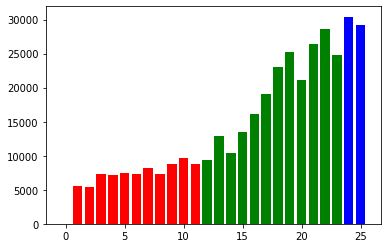

In [115]:
timeline = []
for time in df[["YEAR", "MONTH"]].values.tolist():
    months = 0
    if(time[0] == 2019):
        months += 24
    elif(time[0] == 2018):
        months += 12
    months += time[1]
    timeline.append(months)

    
timeline=  Counter(timeline) 

max_x = max(timeline)
X = list(range(max_x))

Y = []
cc = ["red",'green','blue']
cols = []
ci = 0

for i in X:
    Y.append( timeline[i] )
    if(i >= ci*12+12):
        ci += 1
    cols.append(cc[ci])
    



plt.bar(X,Y, color=cols)

red = 2017  
green = 2018  
blue = 2019  

As we are in August of 2019, it is odd that it stops at February of 2019 as it is said to be updated everyday.  
It is just unbelievable to say that the vandalism has stopped as a whole since February.  
But ok, let's get deeper assuming we select this particular section of the dataset.  
January 2017 to February 2019.

The last bar suggests a slight decline, we'll look at that later.   
First let's clear one thing out.

July 2018 has seen the world championship of football aswell, French are the world champions.  
We want to look at that as it is said that football event often lead stores to close due to high risk of damage to establishments. 

[12, 10, 9, 7, 11, 6, 8, 5, 4, 3, 1, 2]


<BarContainer object of 12 artists>

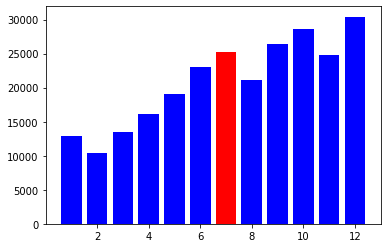

In [116]:
#2018 football championship happened in July 2018

wcs = df[df["YEAR"] == 2018]
wcs = wcs["MONTH"].value_counts()


X = wcs.index.values.tolist()
Y = wcs.values.tolist()

print(X)
cols = ["blue","blue","blue","red","blue","blue" ,"blue","blue","blue","blue","blue","blue"] #aligned to X

plt.bar(X,Y, color = cols)

As we can see the football competition did actually raise the bar, for the summer period at least.  
But declined right after, until another thing takes place around September.  

We can easily assume it's the strong dissatisfaction toward Macron's policies (yellow jackets, black blocks and Benalla's doings).

That might explain part of the vandalism.  
But we'd like to also investigate the consistant vandalism.  

In [117]:
list(df['TYPE'].unique())

['Propreté',
 'Objets abandonnés',
 'Graffitis, tags, affiches et autocollants',
 'Voirie et espace public',
 'Autos, motos, vélos...',
 'Mobiliers urbains',
 'Arbres, végétaux et animaux',
 'Activités commerciales et professionnelles',
 'Eau',
 'Éclairage / Électricité']

There's 10 primary categories of anomalies.  
We'll summarize each categories to give more context and point out categories of interest with a star.  

* **Graffitis, tags, affiches et autocollants**: public vandalism *
* **Voirie et espace public**: Street deterioration 
* **Mobiliers urbains**: urban furniture deterioration *
* **Propreté**: Piss on the street * 
* **Éclairage / Électricité**: malfunctions of public lights
* **Objets abandonnés**: cumbersome objects left on the street (.)
* **Arbres, végétaux et animaux**: dangerous tree or presence of rats, maintenance issue
* **Eau**: flood, water related issues
* **Autos, motos, vélos...**: abandonned/wreck vehicles *
* **Activités commerciales et professionnelles**: flyers with fraudulous use of Paris' logo or colors 

(.) We remove the category "Objets abandonnés" because though it's an incivility, we don't have clear suspects.  
So :
* **Graffitis, tags, affiches et autocollants**
* **Mobiliers urbains**
* **Propreté**
* **Autos, motos, vélos...**


In [118]:
listcat = ["Graffitis, tags, affiches et autocollants", "Mobiliers urbains"]
listdf = []
for cat in listcat:
    listdf.append(df[df["TYPE"] == cat])

listdf.append(df[df["SUBTYPE"].str.contains("Épanchement d'urine") == True ]) # Propreté, just piss
listdf.append(df[df["SUBTYPE"].str.contains("Épave") == True ]) # "Autos, motos, vélos...""

df = pd.concat(listdf)


df.head()

,TYPE,SUBTYPE,POSTAL_CODE,BOROUGH,YEAR,MONTH,NEIGHBORHOOD,LOCATION
1481,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75011,11,2019,1,REPUBLIQUE - SAINT-AMBROISE,"48.8656040012, 2.37350599568"
1483,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75010,10,2019,1,GRANGE AUX BELLES - TERRAGE,"48.87461, 2.36380669348"
1485,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75010,10,2019,1,GRANGE AUX BELLES - TERRAGE,"48.8741069951, 2.36363460175"
1487,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75011,11,2019,1,NATION - ALEXANDRE DUMAS,"48.8491130012, 2.39296820422"
1917,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75011,11,2019,1,REPUBLIQUE - SAINT-AMBROISE,"48.8666269957, 2.37228780059"


In [119]:
df['TYPE'].value_counts()

Graffitis, tags, affiches et autocollants    77214
Autos, motos, vélos...                        9447
Mobiliers urbains                             9316
Propreté                                      5071
Name: TYPE, dtype: int64

In [120]:
df2019 = df[df["YEAR"] == 2019]
df2018 = df[df["YEAR"] == 2018]
df2017 = df[df["YEAR"] == 2017]

print('2019 shape: {}'.format(df2019.shape))
print('2018 shape: {}'.format(df2018.shape))
print('2017 shape: {}'.format(df2017.shape))

df.shape

2019 shape: (8502, 8)
2018 shape: (60693, 8)
2017 shape: (31853, 8)


(101048, 8)

If your machine is powerful, you might want to use more of or the full dataset.  
Mine is getting too old for that.  

In [121]:
sample_size = 2000
sample = df.sample(n=sample_size, random_state = 1) #sampling the dataframe

In [122]:
categories = ["Graffitis, tags, affiches et autocollants", "Mobiliers urbains", "Propreté", "Autos, motos, vélos..."]
colors = ["#10aaf7", "#3c8c47", "#f7cd10", "#f71029"]

m = folium.Map(location=[48.856614, 2.3522219], zoom_start=12)

for cat,col in zip(categories,colors):
    partial_samp = sample[sample["TYPE"] == cat]
    for ind, row in partial_samp.iterrows():
        localisation = list(map(float,row["LOCATION"].split(",")))
        folium.CircleMarker(localisation, radius=1.3, fill=True, color=col).add_to(m)
        #folium.Marker(, popup=row["SUBTYPE"], tooltip=row["TYPE"]).add_to(m)

m

Let's also look at the borough that are the most subject to vandalism

In [123]:
count = df["BOROUGH"].value_counts().to_dict()
rows = []
for k,v in count.items():
    rows.append([k,v])
    
df_arr = pd.DataFrame(rows, columns = ["BOROUGH", "COUNT"])
df_arr

,BOROUGH,COUNT
0,18,12414
1,11,10977
2,10,9004
3,19,8681
4,15,6470
5,12,6150
6,20,5889
7,3,4586
8,13,4555
9,9,4080


In [124]:
m = folium.Map(location=[48.856614, 2.3522219], zoom_start=12)
m.choropleth(
    geo_data=geo,
    data=df_arr,
    columns=['BOROUGH', 'COUNT'],
    key_on='feature.properties.c_ar', #"c_arinsee": 75102, "c_ar": 2
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Vandalism in Paris'
)

# display map
m

As we can see most of the signal comes from upper and eastern side of Paris.  
Living there it does feel like that, and it's known that North-east of Paris is no good news for a business.   
The center have most of the monuments (Eiffel tower, the morned Notre-Dame, etc).  

## Methodology <a name="methodology"></a>

We know there's a disparity of vandalism in the distribution between borough.  
Is it possible to distinguish groups out of this ?   
We'll cluster all signals into k demographic, then according to the type of vandalism, we'll then try to deduce who they are and what are their motivation.  

For each location we'll make a search with Foursquare API and find the establishments in vicinity, and compare their suspected customers to the suspected vandals of the area in order to find a correlation.  

*_We'll then score the results for each area and plot them on a map.  
And then deduce what establishment or furniture attracts the vandals.  
For each location we'd like to deduce a suspect, for that we'll apply a logistic regression using each location's characteristics as features.  
Or a distribution of the demographics with heatmaps._    


* ### clustering

In [125]:
import matplotlib.pyplot as plt
%matplotlib inline


def rand_init(l_min, l_max, L_min, L_max, k):
    l_rand = np.random.uniform(l_min, l_max, k)
    L_rand = np.random.uniform(L_min, L_max, k)

    rand_start = [ np.array([i,j]) for i,j in zip(l_rand,L_rand)]
    return rand_start

def distance( pointA, pointB ):
    return np.linalg.norm( (pointA-pointB) )

def cluster_score(cluster, centroid):
    sum_score = 0
    for point in cluster:
        sum_score += distance( point, centroid )
    return sum_score

def get_score( clusters, centroids ):
    score = 0
    for clus,cent in zip(clusters, centroids):
        score += cluster_score(clus, cent)
    return score

def get_distance_matrix(data_points, centroids, k):
    distance_mat = np.zeros( (len(data_points), k) )
    for i in range(len(data_points)): 
        for j in range(len(centroids)):
            dist = distance(data_points[i], centroids[j])
            distance_mat[i][j] = dist
            
    return distance_mat

def clusterize( data_points, distance_mat, k):  
    clusters = [ [] for n in range(k)]
    for i in range(len(data_points)):
        d = distance_mat[i]
        ind = np.argmin(d)
        clusters[ind].append(data_points[i])
    return clusters

def recenter_centroids(clusters, centroids):
    for i in range(len(centroids)):
        if(len(clusters[i]) == 0):
            continue
        m_lat = np.array([x[0] for x in clusters[i]]).mean()
        m_lon = np.array([y[1] for y in clusters[i]]).mean()
        centroids[i] = np.array( [m_lat,m_lon] )
        
        
def repeat_until_good(score, centroids, data_points, k, eps=1e-5):
    for it in range(10000):
        distance_matrix = get_distance_matrix(data_points, centroids,k)
        clusters = clusterize(data_points, distance_matrix, k)
        new_score = get_score(clusters, centroids)
        difference = score - new_score
        if difference < 0: #worse score
            break
        elif difference < eps: # not significant
            break 
        else:
            score = new_score
        recenter_centroids(clusters, centroids)
    
    return centroids, clusters, score


In [126]:
latitude = []
longitude = []

for ind, row in sample.iterrows():
    lat, lon = tuple(map(float,row["LOCATION"].split(",")))
    latitude.append(lat)
    longitude.append(lon)
    
data_points = [ np.array([i,j]) for i,j in zip(latitude, longitude)]

In [127]:
extension = 0.005
l_min = min(latitude) - extension
l_max = max(latitude) + extension
L_min = min(longitude) - extension
L_max = max(longitude) + extension

l_min, l_max, L_min, L_max

(48.8126035298, 48.9047649985, 2.2442266058700002, 2.41827790284)

33.20289076216409

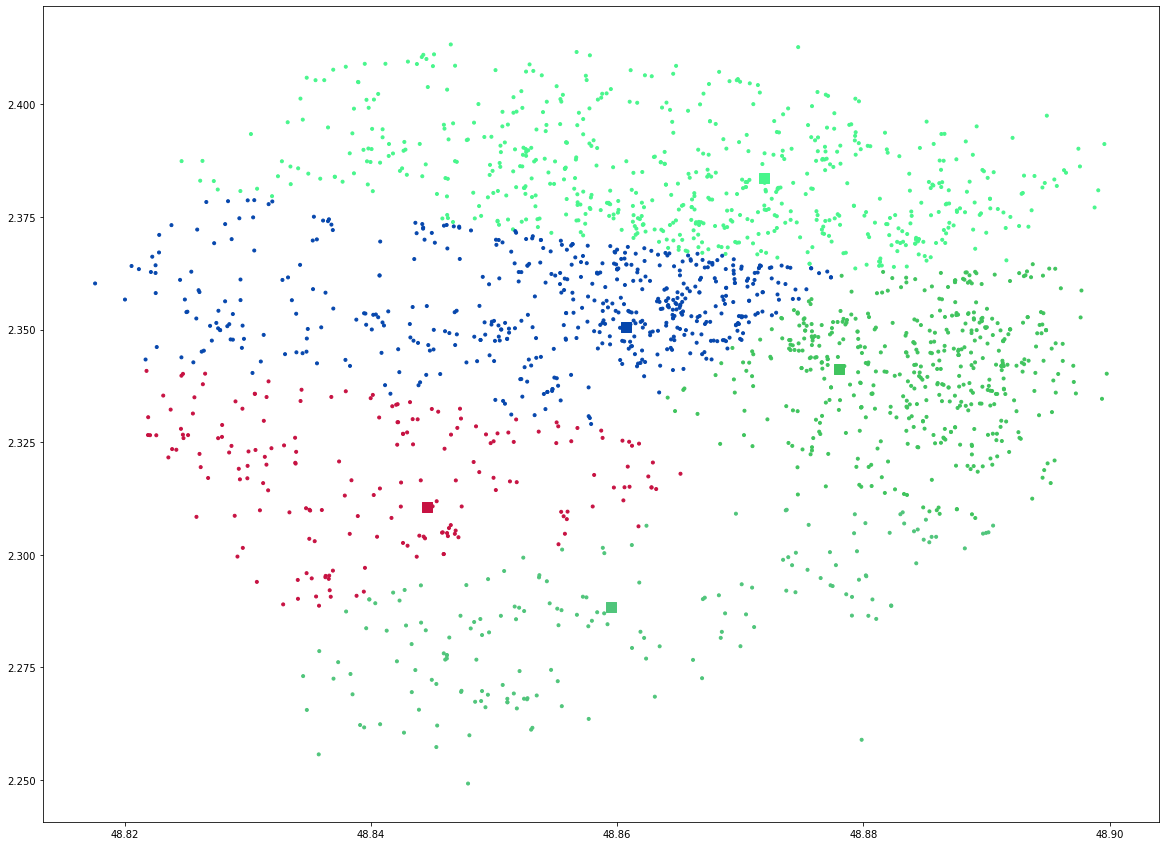

In [128]:
epsilon = 1e-5
#group = ['A','B','C']
#group = ['A','B','C','D']
group = ['A','B','C','D', 'E']
k = len(group)
colors = np.random.rand(k,3)

saves = []

for iteration in range(2000):
    centroids = rand_init(l_min, l_max, L_min, L_max, k) 
    distance_mat = get_distance_matrix(data_points, centroids, k)
    clusters = clusterize(data_points, distance_mat, k)
    score = get_score( clusters, centroids )

    centroids, clusters, score = repeat_until_good(score, centroids, data_points, k, eps= epsilon)
    saves.append( (score, centroids) )
    

best_score, best_centroids = min(saves, key = lambda t: t[0])

best_distance_mat = get_distance_matrix(data_points, best_centroids, k)
best_clusters = clusterize(data_points, best_distance_mat, k)


plt.figure(figsize=(20,15))
plt.scatter( [x[0] for x in best_centroids], [y[1] for y in best_centroids], c= colors, marker = 's', s=100)
for i in range(len(clusters)):
    plt.scatter( [x[0] for x in best_clusters[i]], [y[1] for y in best_clusters[i]], c= [colors[i]]*len(best_clusters[i]), marker='.')
    
best_score

In [129]:
distances = np.zeros(len(best_centroids))
likely_group = []
for ind, row in sample.iterrows():
    point = list(map(float,row["LOCATION"].split(",")))
    for i in range(len(best_centroids)):
        distances[i] = distance(point, best_centroids[i])
    id_grp = np.argmin(distances)
    likely_group.append( group[id_grp] )
    
sample["GROUP"] = likely_group
sample.head()

,TYPE,SUBTYPE,POSTAL_CODE,BOROUGH,YEAR,MONTH,NEIGHBORHOOD,LOCATION,GROUP
136511,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75001,1,2018,9,LES HALLES,"48.8604160019, 2.34749100246",C
17157,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75004,4,2017,7,SAINT-MERRI,"48.8588983309, 2.35203741829",C
476138,"Graffitis, tags, affiches et autocollants","Affiches, autocollants ou graffitis sur statue...",75006,6,2018,3,MONNAIE,"48.853434899, 2.3437226641",C
453532,"Graffitis, tags, affiches et autocollants","Affiches, autocollants ou graffitis sur autres...",75015,15,2018,6,CITROEN - BOUCICAUT,"48.8369669989, 2.27250839887",D
154407,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75018,18,2018,9,CLIGNANCOURT - JULES JOFFRIN,"48.8939700003, 2.34037729773",E


look at each group most common vandalism type and deduce a demographic

In [130]:
groupA = sample[sample["GROUP"] == "A"]

print(groupA.shape)
groupA["TYPE"].value_counts() *100 / groupA["TYPE"].value_counts().sum()

(188, 9)


Graffitis, tags, affiches et autocollants    75.000000
Autos, motos, vélos...                       14.361702
Mobiliers urbains                             8.510638
Propreté                                      2.127660
Name: TYPE, dtype: float64

In [131]:
groupB = sample[sample["GROUP"] == "B"]

print(groupB.shape)
groupB["TYPE"].value_counts() *100 / groupB["TYPE"].value_counts().sum()

(621, 9)


Graffitis, tags, affiches et autocollants    76.650564
Mobiliers urbains                            10.466989
Autos, motos, vélos...                        8.212560
Propreté                                      4.669887
Name: TYPE, dtype: float64

In [132]:
groupC = sample[sample["GROUP"] == "C"]

print(groupC.shape)
groupC["TYPE"].value_counts() *100 / groupC["TYPE"].value_counts().sum()

(539, 9)


Graffitis, tags, affiches et autocollants    82.374768
Autos, motos, vélos...                        7.235622
Mobiliers urbains                             6.864564
Propreté                                      3.525046
Name: TYPE, dtype: float64

In [133]:
groupD = sample[sample["GROUP"] == "D"]

print(groupD.shape)
groupD["TYPE"].value_counts() *100 / groupD["TYPE"].value_counts().sum()

(171, 9)


Graffitis, tags, affiches et autocollants    63.742690
Autos, motos, vélos...                       21.637427
Mobiliers urbains                            13.450292
Propreté                                      1.169591
Name: TYPE, dtype: float64

In [134]:
groupE = sample[sample["GROUP"] == "E"]

print(groupE.shape)
groupE["TYPE"].value_counts() *100 / groupE["TYPE"].value_counts().sum()

(481, 9)


Graffitis, tags, affiches et autocollants    74.636175
Propreté                                      9.563410
Autos, motos, vélos...                        7.900208
Mobiliers urbains                             7.900208
Name: TYPE, dtype: float64

The proportions doesn't allow us to draw clear geospatial limits as it's not so different between clusters.    

Some categories seems very close, especially "Autos, motos, vélos..." and "Mobiliers urbains".  
We want to look if they are correlated, if it's the case we can group them as one class.  

Oterwise, we can't say the type of crime is geographically distinct.   
Where vandalism happen, it happens in about the same proportion.

In [135]:
from collections import Counter 

autos = sample[sample["TYPE"] == "Autos, motos, vélos..."]
mobil = sample[sample["TYPE"] == "Mobiliers urbains"]

autos_timeline = []
for time in autos[["YEAR", "MONTH"]].values.tolist():
    months = 0
    if(time[0] == 2019):
        months += 24
    elif(time[0] == 2018):
        months += 12
    months += time[1]
    autos_timeline.append(months)

mobil_timeline = []
for time in mobil[["YEAR", "MONTH"]].values.tolist():
    months = 0
    if(time[0] == 2019):
        months += 24
    elif(time[0] == 2018):
        months += 12
    months += time[1]
    mobil_timeline.append(months)
    
autos_timeline=  Counter(autos_timeline) 
mobil_timeline=  Counter(mobil_timeline)

max_x = max( max(autos_timeline), max(mobil_timeline) )
X = list(range(max_x))

autos_Y = []
mobil_Y = []

for i in X:
    autos_Y.append( autos_timeline[i] )
    mobil_Y.append( mobil_timeline[i] )
    

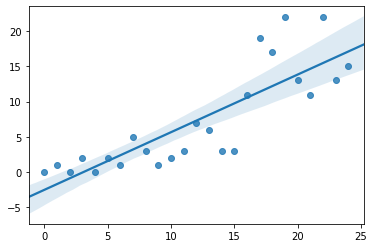

In [136]:
import seaborn as sns

sns.regplot(x= X, y=autos_Y)

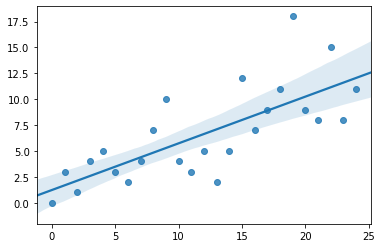

In [137]:
sns.regplot(x= X, y=mobil_Y)

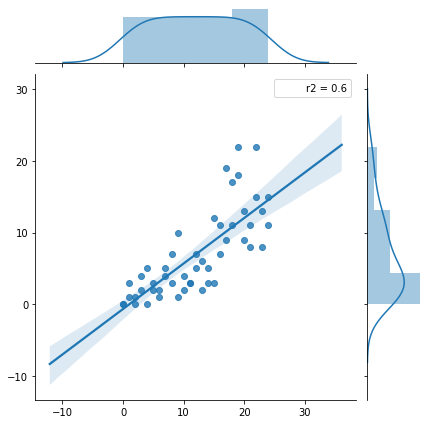

In [138]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

Y = autos_Y + mobil_Y
X2 = X + X

sns.jointplot(x= X2, y=Y, kind="reg", stat_func=r2)

R2 = 0.6 is a somewhat strong correlation, we'll group these two as both are destruction of vehicles or furnitures, we'll name the group 'destruction'. 

In [151]:
sample.loc[sample["TYPE"] ==  "Mobiliers urbains", ["TYPE"]] = "Destruction"
sample.loc[sample["TYPE"] ==  "Autos, motos, vélos...", ["TYPE"]] = "Destruction"

sample.head(10)

,TYPE,SUBTYPE,POSTAL_CODE,BOROUGH,YEAR,MONTH,NEIGHBORHOOD,LOCATION,GROUP
136511,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75001,1,2018,9,LES HALLES,"48.8604160019, 2.34749100246",C
17157,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75004,4,2017,7,SAINT-MERRI,"48.8588983309, 2.35203741829",C
476138,"Graffitis, tags, affiches et autocollants","Affiches, autocollants ou graffitis sur statue...",75006,6,2018,3,MONNAIE,"48.853434899, 2.3437226641",C
453532,"Graffitis, tags, affiches et autocollants","Affiches, autocollants ou graffitis sur autres...",75015,15,2018,6,CITROEN - BOUCICAUT,"48.8369669989, 2.27250839887",D
154407,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75018,18,2018,9,CLIGNANCOURT - JULES JOFFRIN,"48.8939700003, 2.34037729773",E
420707,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75004,4,2018,11,LES ILES,"48.8495999983, 2.36004600332",C
479152,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75018,18,2018,3,AMIRAUX - SIMPLON - POISSONNIERS,"48.8929670029, 2.35151929889",E
43066,Destruction,Épave de vélo,75020,20,2018,1,GAMBETTA,"48.8647899974, 2.40852799935",B
217198,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75013,13,2017,11,DUNOIS - BIBLIOTHEQUE - JEANNE-D'ARC,"48.8361200003, 2.37418839429",C
533949,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75004,4,2018,6,SAINT-GERVAIS,"48.8553729971, 2.3625585947",C


So we'll have only 3 categories

* Graffitis, tags, affiches et autocollants
* Propreté
* Destruction

We can also note that both of these 2 type of vandalism or "Destruction" for instance, raised steadily over the past 3 years.  
And it is from none to about 10 per month in one city.  

Is it also the case for the other types ? 

In [139]:
graf = sample[sample["TYPE"] == "Graffitis, tags, affiches et autocollants"]
prop = sample[sample["TYPE"] == "Propreté"]

graf_timeline = []
for time in graf[["YEAR", "MONTH"]].values.tolist():
    months = 0
    if(time[0] == 2019):
        months += 24
    elif(time[0] == 2018):
        months += 12
    months += time[1]
    graf_timeline.append(months)

prop_timeline = []
for time in prop[["YEAR", "MONTH"]].values.tolist():
    months = 0
    if(time[0] == 2019):
        months += 24
    elif(time[0] == 2018):
        months += 12
    months += time[1]
    prop_timeline.append(months)
    
graf_timeline=  Counter(graf_timeline) 
prop_timeline=  Counter(prop_timeline)

max_x = max( max(graf_timeline), max(prop_timeline) )
X = list(range(max_x))

graf_Y = []
prop_Y = []

for i in X:
    graf_Y.append( graf_timeline[i] )
    prop_Y.append( prop_timeline[i] )

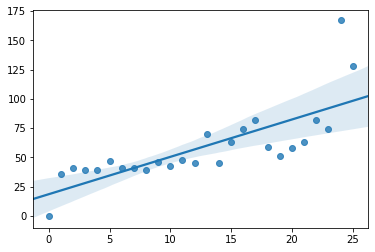

In [140]:
sns.regplot(x= X, y=graf_Y)

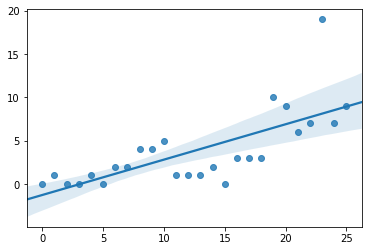

In [141]:
sns.regplot(x= X, y=prop_Y)

It's also clear that the trend is upward for these too.  
So basically all types of vandalism are raising in Paris.

In [106]:
df = df[df["TYPE"] != "Mobiliers urbains"]

sample = df.sample(sample_size, random_state=1)
sample.head()

,TYPE,SUBTYPE,POSTAL_CODE,BOROUGH,YEAR,MONTH,NEIGHBORHOOD,LOCATION
393945,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75019,19,2017,6,BASSIN DE LA VILLETTE,"48.8898865734, 2.38493873445"
359452,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75012,12,2018,11,ALIGRE - GARE DE LYON,"48.8484799995, 2.37519239932"
56333,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75011,11,2018,3,BELLEVILLE - SAINT-MAUR,"48.8689387059, 2.37273574553"
451966,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75018,18,2018,1,GOUTTE D'OR - CHATEAU ROUGE,"48.8851606376, 2.34738773071"
416751,"Graffitis, tags, affiches et autocollants","Affiches ou autocollants sur mur, façade sur r...",75008,8,2018,12,MAIRIE,"48.875202003, 2.32640480535"


We can also see each categories as its own class, we can divide the dataframe and look at each class separately. 

One of the thing that i dislike in Paris is the amount of piss on the street, and it pisses me off. See what i did there ?  
Ok, we'll just focus on the type "Propreté". The methodology will be the same for the other types.  

In [152]:
#Foursquare credentials

CLIENT_ID = 'TIB5BOKHV15HM5FOTPBXEBZ5PYDHBQ5SD2P2DWAQAR2QNB1U' 
CLIENT_SECRET = 'SLXTUVU1MHMNKRMTAO1TR413FHAI1RLTT1CI4FMAHAAQOBRA'
VERSION = '20190807'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TIB5BOKHV15HM5FOTPBXEBZ5PYDHBQ5SD2P2DWAQAR2QNB1U
CLIENT_SECRET:SLXTUVU1MHMNKRMTAO1TR413FHAI1RLTT1CI4FMAHAAQOBRA


In [153]:
def type_of_venues(dataframe):
    venues = []
    for ind, row in dataframe.iterrows():
        cat = row["categories"]
        if(len(cat)==0):
            venues.append("No venues")
            continue
        cat = cat[0]
        venues.append( cat["name"] )
    return venues

In [158]:
radius = 15

venues_list = []
venues_all = []

for ind, row in sample.iterrows():
    
    local = row["LOCATION"].split(',')
    local = list( map(float, local) )
    latitude = local[0]
    longitude = local[1]
    
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
    
    #results = requests.get(url).json()
    r = requests.get(url)
    if 'json' in r.headers.get('Content-Type'):
        results = r.json()
    else:
        print('Response content is not in JSON format.')
        sample.drop(ind, inplace=True)
        continue

    try:
        venues = results['response']['venues']
    except KeyError:
        print(results)
        print("Retry...")
        try:
            results = requests.get(url).json()
            venues = results['response']['venues']
        except KeyError:
            print("2 failed atempts, drop row")
            print(row)
            sample.drop(ind, inplace=True)
            continue
            
    dataframe = json_normalize(venues)
    
    venues_list.append(type_of_venues(dataframe))
    venues_all.extend(type_of_venues(dataframe))
    
    
sample["VENUES"] = venues_list
sample.head()

,TYPE,SUBTYPE,POSTAL_CODE,BOROUGH,YEAR,MONTH,NEIGHBORHOOD,LOCATION,GROUP,VENUES
136511,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75001,1,2018,9,LES HALLES,"48.8604160019, 2.34749100246",C,"[Café, Plaza, Thai Restaurant, Cocktail Bar, M..."
17157,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75004,4,2017,7,SAINT-MERRI,"48.8588983309, 2.35203741829",C,"[Theater, Art Museum, Art Gallery, Gym, Founta..."
476138,"Graffitis, tags, affiches et autocollants","Affiches, autocollants ou graffitis sur statue...",75006,6,2018,3,MONNAIE,"48.853434899, 2.3437226641",C,"[Plaza, Metro Station, Fountain, Bistro, Brass..."
453532,"Graffitis, tags, affiches et autocollants","Affiches, autocollants ou graffitis sur autres...",75015,15,2018,6,CITROEN - BOUCICAUT,"48.8369669989, 2.27250839887",D,"[Office, Building, Coffee Shop, TV Station, Of..."
154407,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75018,18,2018,9,CLIGNANCOURT - JULES JOFFRIN,"48.8939700003, 2.34037729773",E,"[Performing Arts Venue, Bike Shop, African Res..."


In [159]:
venues_all[0:15]

['Café',
 'Plaza',
 'Thai Restaurant',
 'Cocktail Bar',
 'Metro Station',
 'Historic Site',
 'Bookstore',
 'Hotel',
 'Bar',
 'Gay Bar',
 'Bar',
 'Fountain',
 'Hotel',
 'Leather Goods Store',
 'Bar']

In [160]:
from collections import Counter

most_common_venues = list(Counter(venues_all).most_common())
most_common_venues

[('Bar', 2900),
 ('Residential zone', 2605),
 ('Hotel', 2190),
 ('French Restaurant', 2170),
 ('Bakery', 1756),
 ('Office', 1544),
 ('Plaza', 1290),
 ('Residential Building (Apartment / Condo)', 1135),
 ('Café', 1133),
 ('Metro Station', 963),
 ('Bus Stop', 936),
 ('Italian Restaurant', 812),
 ('Supermarket', 808),
 ('Art Gallery', 785),
 ('Salon / Barbershop', 698),
 ('Bank', 655),
 ('Restaurant', 642),
 ('Pizza Place', 635),
 ('Park', 601),
 ('Pharmacy', 600),
 ('Bike Rental / Bike Share', 548),
 ('Chinese Restaurant', 507),
 ('Garden', 505),
 ('Bistro', 498),
 ('Building', 480),
 ('Japanese Restaurant', 459),
 ('Bookstore', 443),
 ('Grocery Store', 443),
 ('Tech Startup', 429),
 ('Church', 412),
 ('Clothing Store', 388),
 ('Asian Restaurant', 381),
 ('Coffee Shop', 379),
 ('Food & Drink Shop', 360),
 ('Sandwich Place', 351),
 ('Fast Food Restaurant', 343),
 ('Post Office', 326),
 ('Cocktail Bar', 322),
 ('Indian Restaurant', 315),
 ('Lounge', 311),
 ('Coworking Space', 305),
 ('Wine

In [161]:
prop = sample[sample["TYPE"] == 'Propreté']

all_venues_prop = []
for ind, row in prop.iterrows():
    all_venues_prop.extend(row["VENUES"])

Counter(all_venues_prop).most_common()

[('Bar', 174),
 ('Residential zone', 139),
 ('French Restaurant', 122),
 ('Hotel', 119),
 ('Bakery', 88),
 ('Café', 77),
 ('Plaza', 71),
 ('Office', 68),
 ('Residential Building (Apartment / Condo)', 67),
 ('Metro Station', 64),
 ('Supermarket', 43),
 ('Restaurant', 40),
 ('Bus Stop', 40),
 ('Salon / Barbershop', 34),
 ('Lounge', 33),
 ('Bank', 33),
 ('Indian Restaurant', 30),
 ('Bike Rental / Bike Share', 29),
 ('Pizza Place', 29),
 ('Pharmacy', 27),
 ('Fast Food Restaurant', 26),
 ('Italian Restaurant', 26),
 ('Park', 23),
 ('Art Gallery', 22),
 ('Farmers Market', 21),
 ('African Restaurant', 21),
 ('Building', 20),
 ('Chinese Restaurant', 20),
 ('Food & Drink Shop', 20),
 ('Coffee Shop', 19),
 ('Cocktail Bar', 19),
 ('Church', 19),
 ('Gym / Fitness Center', 18),
 ('Post Office', 17),
 ('Theater', 17),
 ('Cosmetics Shop', 17),
 ('Sandwich Place', 17),
 ('Bookstore', 17),
 ('Bistro', 17),
 ('Brewery', 16),
 ('Convenience Store', 16),
 ('Cheese Shop', 16),
 ('Tech Startup', 16),
 ('Gym

The most likely venues near any signals are 'Bar'.  
Is there a correlation between them ?  
Let's check out. 

The following code has been inspired from the notebook : https://cocl.us/coursera_capstone_notebook  
You might want to check it out if what it does is not clear for you.  

In [162]:
paris_center = [48.866667, 2.333333]

In [163]:
import shapely.geometry
import pyproj
import math

def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

x, y = lonlat_to_xy(paris_center[1], paris_center[0])
lo, la = xy_to_lonlat(x, y)

In [164]:
paris_center_x, paris_center_y = lonlat_to_xy(paris_center[1], paris_center[0]) # City center in Cartesian coordinates

k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
x_min = paris_center_x - 6000
x_step = 600
y_min = paris_center_y - 6000 - (int(21/k)*k*600 - 12000)/2
y_step = 600 * k 

latitudes = []
longitudes = []
distances_from_center = []
xs = []
ys = []
for i in range(0, int(21/k)):
    y = y_min + i * y_step
    x_offset = 300 if i%2==0 else 0
    for j in range(0, 21):
        x = x_min + j * x_step + x_offset
        distance_from_center = calc_xy_distance(paris_center_x, paris_center_y, x, y)
        if (distance_from_center <= 6001):
            lon, lat = xy_to_lonlat(x, y)
            latitudes.append(lat)
            longitudes.append(lon)
            distances_from_center.append(distance_from_center)
            xs.append(x)
            ys.append(y)

print(len(latitudes), 'candidate neighborhood centers generated.')

364 candidate neighborhood centers generated.


In [165]:
import folium

map_paris = folium.Map(location=paris_center, zoom_start=13)
folium.Marker(paris_center).add_to(map_paris)
for lat, lon in zip(latitudes, longitudes):
    folium.Circle([lat, lon], radius=300, color='blue', fill=False).add_to(map_paris)
map_paris

In [167]:
radius = 350
LIMIT = 100

venues_location = []

for lat, lon in zip(latitudes, longitudes):
    #url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
    
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lon, VERSION, radius, LIMIT)
    
    r = requests.get(url)
    if 'json' in r.headers.get('Content-Type'):
        try:
            results = r.json()['response']['groups'][0]['items']
        except KeyError:
            print(r.json())
    else:
        print('Response content is not in JSON format.')

    try: 
        venues = [ ( get_categories(item['venue']['categories']),
                     (item['venue']['location']['lat'], item['venue']['location']['lng']) ) 
                  for item in results ]  
        
        #filter french restaurant out of the bunch
        for v in venues:
            if (v[0][0][0] == 'Bar'):
                location = [ v[1][0], v[1][1] ]
                venues_location.append(location)
    except:
        venues = []
        
venues_location[0:5]

{'meta': {'code': 403, 'errorType': 'rate_limit_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5d4b6e21a3061900381cb485'}, 'response': {}}
{'meta': {'code': 403, 'errorType': 'rate_limit_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5d4b6e2122be1200253192a0'}, 'response': {}}
{'meta': {'code': 403, 'errorType': 'rate_limit_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5d4b6e218ad62e00393e95b7'}, 'response': {}}
{'meta': {'code': 403, 'errorType': 'rate_limit_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5d4b6e22531593002c85ad91'}, 'response': {}}
{'meta': {'code': 403, 'errorType': 'rate_limit_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5d4b6e228fbe780023fc1110'}, 'response': {}}
{'meta': {'code': 403, 'errorType': 'rate_limit_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5d4b6e227f797700253c0ae4'}, 'response': {}}
{'meta': {'code': 403, 'errorType': 'rate_limit_exceeded', 'errorDetail': 'Quota exceeded', 'request

{'meta': {'code': 403, 'errorType': 'rate_limit_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5d4b6e2aad1789002cad92a1'}, 'response': {}}
{'meta': {'code': 403, 'errorType': 'rate_limit_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5d4b6e2ae97dfb002c42db31'}, 'response': {}}
{'meta': {'code': 403, 'errorType': 'rate_limit_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5d4b6e2a8fc77c002fcbb6d1'}, 'response': {}}
{'meta': {'code': 403, 'errorType': 'rate_limit_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5d4b6e2b018cbb002c22a365'}, 'response': {}}
{'meta': {'code': 403, 'errorType': 'rate_limit_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5d4b6e2bbf7dde002c238b8d'}, 'response': {}}
{'meta': {'code': 403, 'errorType': 'rate_limit_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5d4b6e2b6adbf5002c81c063'}, 'response': {}}
{'meta': {'code': 403, 'errorType': 'rate_limit_exceeded', 'errorDetail': 'Quota exceeded', 'request

[[48.82681, 2.327157],
 [48.82757341292547, 2.348275832727528],
 [48.82777052296149, 2.349528141219503],
 [48.82771808662243, 2.3500100148529466],
 [48.82767912046911, 2.3503687977790833]]

In [168]:
len( venues_location )  #number of venues located

375

In [171]:
m = folium.Map(location=[48.856614, 2.3522219], zoom_start=12)

for loc in venues_location:
    folium.CircleMarker(loc, radius=1.3, fill=True, color='red').add_to(m)

m

In [173]:
p_m = m

for ind, row in prop.iterrows():
    loc = list(map(float,row["LOCATION"].split(",")))
    folium.CircleMarker(loc, radius=1.3, fill=True, color='blue').add_to(p_m)
    
p_m

**Blue** are signals of piss  
**Red** are Bar location  

This doesn't look promising, visually speaking the Bar are less present in the north east area.  
We can see a somewhat superposition in the north area but then can't explain the north west part.  
There's most likely no correlation between the two.  

And likely account for the other venues and categories too.  
That effectively exhaust our pists.

In [ ]:
It looks promising actually

In [180]:
des = sample[sample["TYPE"] == 'Destruction']

all_venues_des = []
for ind, row in des.iterrows():
    all_venues_des.extend(row["VENUES"])

Counter(all_venues_des).most_common()

[('Residential zone', 518),
 ('Bar', 421),
 ('French Restaurant', 408),
 ('Hotel', 399),
 ('Office', 333),
 ('Bakery', 302),
 ('Plaza', 257),
 ('Residential Building (Apartment / Condo)', 217),
 ('Café', 195),
 ('Bus Stop', 194),
 ('Italian Restaurant', 154),
 ('Metro Station', 145),
 ('Supermarket', 142),
 ('Park', 134),
 ('Restaurant', 126),
 ('Bank', 120),
 ('Art Gallery', 115),
 ('Bike Rental / Bike Share', 114),
 ('Pharmacy', 112),
 ('Salon / Barbershop', 111),
 ('Pizza Place', 107),
 ('Garden', 97),
 ('Japanese Restaurant', 96),
 ('Building', 94),
 ('Grocery Store', 88),
 ('Chinese Restaurant', 85),
 ('Bistro', 83),
 ('Coworking Space', 82),
 ('Tech Startup', 82),
 ('Asian Restaurant', 80),
 ('Food & Drink Shop', 75),
 ('Government Building', 74),
 ('Coffee Shop', 69),
 ('Post Office', 66),
 ('Sandwich Place', 66),
 ('Bookstore', 64),
 ('Church', 64),
 ('Playground', 64),
 ("Doctor's Office", 58),
 ('Train Station', 57),
 ('Fast Food Restaurant', 56),
 ('Wine Shop', 55),
 ('Cockt

In [179]:
graf = sample[sample["TYPE"] == 'Graffitis, tags, affiches et autocollants']

all_venues_graf = []
for ind, row in graf.iterrows():
    all_venues_graf.extend(row["VENUES"])

Counter(all_venues_graf).most_common()

[('Bar', 2305),
 ('Residential zone', 1948),
 ('Hotel', 1672),
 ('French Restaurant', 1640),
 ('Bakery', 1366),
 ('Office', 1143),
 ('Plaza', 962),
 ('Café', 861),
 ('Residential Building (Apartment / Condo)', 851),
 ('Metro Station', 754),
 ('Bus Stop', 702),
 ('Art Gallery', 648),
 ('Italian Restaurant', 632),
 ('Supermarket', 623),
 ('Salon / Barbershop', 553),
 ('Bank', 502),
 ('Pizza Place', 499),
 ('Restaurant', 476),
 ('Pharmacy', 461),
 ('Park', 444),
 ('Bike Rental / Bike Share', 405),
 ('Chinese Restaurant', 402),
 ('Bistro', 398),
 ('Garden', 394),
 ('Building', 366),
 ('Bookstore', 362),
 ('Japanese Restaurant', 350),
 ('Grocery Store', 344),
 ('Tech Startup', 331),
 ('Clothing Store', 329),
 ('Church', 329),
 ('Asian Restaurant', 293),
 ('Coffee Shop', 291),
 ('Sandwich Place', 268),
 ('Food & Drink Shop', 265),
 ('Fast Food Restaurant', 261),
 ('Wine Bar', 251),
 ('Cocktail Bar', 250),
 ('Post Office', 243),
 ('Wine Shop', 239),
 ('Indian Restaurant', 236),
 ('Vietnamese 

## Results and Discussion <a name="results"></a>

First of all, we can say that vandalism from all kind are raising steadily.  
And they are most common in the north-east areas of Paris.  

Our geospatial analysis can't explain the recent raise.
But socially speaking it is obvious that it is all due to the strong dissatisfaction toward Macron's policy on gas.  

The dataset used might not be suited or incomplete for this case.  
This study was only based on my knowledges and ideas, there's probably more pists to explore.

## Conclusion <a name="conclusion"></a>

For starters, France could really use to have more public sanitaries by looking at the number of complaint for piss on public area.  

I feel like the problem remains in the government that unintentionnally encourage vandalism as an act of protest.  
The yellow vest movement started pacifically, but they were not heard until vandalism shows up.   

In the end, we need to keep in mind these are signals gathered by the crowd and not professionnal dataset.  
By the numbers we would tend to say French restaurant attracts vandals and therefore generates vandalism.  
But it can also mean that customers of French restaurants are more attentive to the surroundings and tends to signal when there's something wrong.  
There's also the notion of redundancy, many signals may be pointing to the same problem.  
Also not everybody care or know about it, a more serious dataset might give better results.    
   
This analysis proves one more time that statistics can say about anything.  
As Ronald Coase said, "if you torture long enough the data, it will confess".  